In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from forecasters import feature_factory as ff
from forecasters import boosted_hybrid as bh

In [150]:
import importlib
importlib.reload(ff)
importlib.reload(bh)

<module 'forecasters.boosted_hybrid' from '/home/shem/repos/eforecast/forecasters/boosted_hybrid.py'>

In [151]:
df_daily = pd.read_csv("test_data/df_daily_test_data.csv", parse_dates=["ts"], 
                       index_col=["ts"]).rename(columns={"energy_kWh": "y"})

In [152]:
df_daily.head(3)

,y
ts,
2012-06-21,3.730
2012-06-22,4.400
2012-06-23,4.965


In [153]:
# Get weather data
weather = pd.read_csv("test_data/london_weather.csv", usecols=["tempmax", "tempmin", "temp",
                                                              "feelslike", "sunrise", "sunset",
                                                              "datetime"],
                     parse_dates=["datetime"], index_col=["datetime"])

In [154]:
# Combine weather data with target data
df_input = pd.concat([df_daily, weather], axis=1, ignore_index=False)
df_input.head(3)

,y,tempmax,tempmin,temp,feelslike,sunrise,sunset
2012-06-21,3.730,19.3,11.6,15.8,15.8,2012-06-21T04:43:14,2012-06-21T21:21:32
2012-06-22,4.400,18.3,11.5,14.9,14.9,2012-06-22T04:43:29,2012-06-22T21:21:40
2012-06-23,4.965,18.5,10.8,14.8,14.8,2012-06-23T04:43:47,2012-06-23T21:21:46


In [155]:
factory = ff.FeatureFactory(df_input)

In [156]:
X_trend = factory.create_time_trend_features(order=1)

Creating time trend features of order: 1


In [157]:
X_lag = factory.create_lag_features(lag_steps=7)

Creating lag features of lag: 7


In [158]:
X_seasonal = factory.create_fourier_features(freq="y", fourier_order=12)

Creating seasonal features for Fourier freq: y and Fourier order: 12


In [159]:
X_statistical = factory.create_statistical_features(mean_window=7, median_window=7, stdev_window=7)

Creating rolling window statistical features of mean_7, median_7, stdev7


In [160]:
X_temperature = factory.create_temperature_features(["temp", "feelslike"])

Creating temperature feature for ['temp', 'feelslike']


In [161]:
X_daylength = factory.create_daylength_features("sunrise", "sunset")

Creating daylength feature using cols: ('sunrise', 'sunset')


In [162]:
# Quick visualisation - Linear regression with seaborn

# fig, ax = plt.subplots(figsize=(14, 5.5))
# #ax.plot("feelslke", "y", data=df_input, color="0.75")
# ax = sns.regplot(x="feelslike", y="y", data=df_input, ci=None,
#                 scatter_kws=dict(color="0.25"))

In [163]:
# Quick visualisation - Linear regression with seaborn

# fig, ax = plt.subplots(figsize=(14, 5.5))
# #ax.plot("feelslke", "y", data=df_input, color="0.75")
# ax = sns.regplot(x="temp", y="y", data=df_input, ci=None,
#                 scatter_kws=dict(color="0.25"))

In [164]:
#

In [165]:
# add the target y so we can drop nans across rows
# X_all = factory.combine_features([X_trend, X_lag, X_statistical, X_seasonal, df_daily.y])

In [166]:
X_all = factory.combine_features([X_trend, X_lag, X_statistical, X_seasonal, X_temperature,
                                          X_daylength, df_daily.y])

In [167]:
X_all.columns

Index(['const', 'trend', 'ylag_7', 'mean_7', 'median_7', 'stdev_7', 'const',
       's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)',
       'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'sin(3,freq=A-DEC)', 'cos(3,freq=A-DEC)',
       'sin(4,freq=A-DEC)', 'cos(4,freq=A-DEC)', 'sin(5,freq=A-DEC)',
       'cos(5,freq=A-DEC)', 'sin(6,freq=A-DEC)', 'cos(6,freq=A-DEC)',
       'sin(7,freq=A-DEC)', 'cos(7,freq=A-DEC)', 'sin(8,freq=A-DEC)',
       'cos(8,freq=A-DEC)', 'sin(9,freq=A-DEC)', 'cos(9,freq=A-DEC)',
       'sin(10,freq=A-DEC)', 'cos(10,freq=A-DEC)', 'sin(11,freq=A-DEC)',
       'cos(11,freq=A-DEC)', 'sin(12,freq=A-DEC)', 'cos(12,freq=A-DEC)',
       'temp', 'feelslike', 'daylength', 'y'],
      dtype='object')

## Train lin reg model and plot results
 - Here just testing self predict (same training and prediction data)

In [168]:
# Drop NaNs and set up the X and y dfs

X_all = X_all.dropna(axis=0)

X = X_all.drop(columns=["y"])
y = X_all.y

# Train model
model = LinearRegression()
model.fit(X, y)

# Store fitted values a new time series
y_pred = pd.Series(model.predict(X), index=X.index)

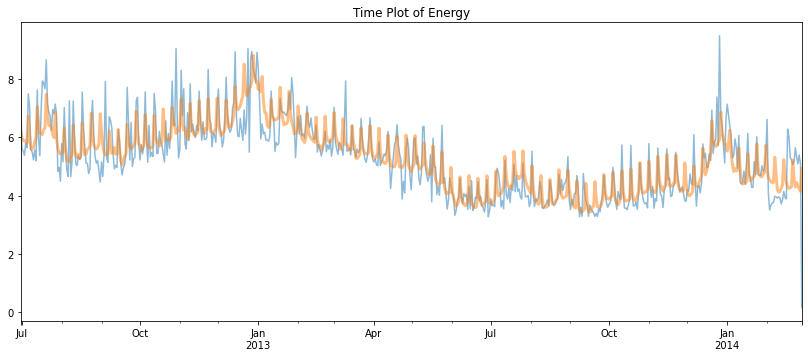

score: 0.7335604720275575
coeff: [ 6.89964800e-11 -6.47132036e-03  1.14441637e-01 -3.10540938e-01
 -7.70370391e-02  4.53419051e-02  5.05545605e-12  8.18944199e-01
  2.14317233e-01 -2.77326390e-02 -7.82429792e-02 -1.04165282e-01
 -7.13781511e-02  2.19886610e+01 -1.08942360e+02 -1.02993474e-02
 -8.05158438e-01  2.09447810e+00 -3.16797765e+00  2.53762345e-01
 -2.64938035e-02  5.83630685e-02  1.03076308e-02  8.93152770e-02
  1.48627924e-01 -8.24565176e-02  8.67508845e-02 -1.31605427e-02
  5.37774611e-02 -8.28067640e-02  1.21934499e-01 -9.41602543e-02
 -2.85452973e-02 -1.38057086e-02  8.40765369e-02 -8.14973464e-02
  4.01329312e-02  8.61974540e-03 -2.53197929e-02 -2.64160177e+01]
intercept: 332.9411863625231


In [169]:
ax = y.plot(alpha=0.5, figsize=(14, 5.5))
ax = y_pred.plot(ax=ax, linewidth=3, alpha=0.5)
ax.set_title("Time Plot of Energy")
plt.show()

print(f"score: {model.score(X, y)}")
print(f"coeff: {model.coef_}") 
print(f"intercept: {model.intercept_}")

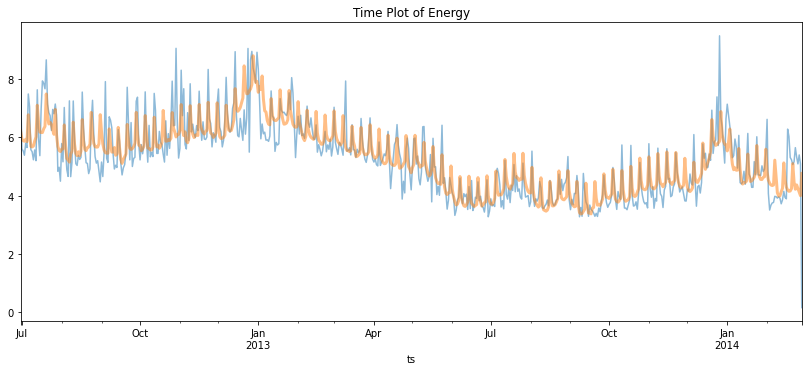

score: 0.7289693385319076
coeff: [ 1.53114846e-14 -6.10302186e-03  1.08134514e-01 -2.18232938e-01
 -1.21042841e-01  3.22370392e-02 -5.55111512e-17  8.27365124e-01
  2.18591985e-01 -2.20084296e-02 -8.22640288e-02 -1.07663781e-01
 -7.29718905e-02  3.36988396e-01  1.07703222e+00  4.51357936e-02
  2.39994926e-01 -1.37212222e-01  2.10127425e-01  1.84108310e-01
  8.95924488e-02 -1.36871597e-01  1.35930730e-01  7.85660304e-02
  1.41381883e-01 -1.08902723e-01  7.96791278e-02 -2.36232512e-02
  6.07032279e-02 -6.78360814e-02  1.12148393e-01 -8.25201783e-02
 -4.38547816e-02 -1.92309475e-02  6.68173325e-02 -8.86471256e-02
  4.27249148e-02]
intercept: 8.20495108850182


In [12]:
ax = y.plot(alpha=0.5, figsize=(14, 5.5))
ax = y_pred.plot(ax=ax, linewidth=3, alpha=0.5)
ax.set_title("Time Plot of Energy")
plt.show()

print(f"score: {model.score(X, y)}")
print(f"coeff: {model.coef_}") 
print(f"intercept: {model.intercept_}")

## Boosted Hybrid

In [176]:
# X_1: Features for Linear Regression
X_all = factory.combine_features([X_trend, X_lag, X_statistical, X_seasonal, X_temperature,
                                          X_daylength, df_daily.y])
X_all = X_all.dropna(axis=0)

X_1 = X_all.drop(columns=["y"])
y = X_all[["y"]]

In [177]:
# X_2: Features for XGBoost
X_2 = factory.combine_features([X_lag, X_statistical, X_temperature,
                                          X_daylength])

# all the nans in this case are in X_statistical so it'll work but this isn't always the case
X_2 = X_2.dropna(axis=0)

# Label encoding for day of week
X_2["day"] = X_2.index.day_of_week

In [178]:
# Initialise boost class 
importlib.reload(bh)
model = bh.BoostedHybrid(model_1=LinearRegression(), 
                      model_2=XGBRegressor())

In [179]:
model.fit(X_1, X_2, y)

In [180]:
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

In [181]:
y_pred.head(3)

,y_pred,y_pred_boosted
2012-06-30,6.241765,7.869948
2012-07-01,5.982728,5.642884
2012-07-02,5.927682,5.545251


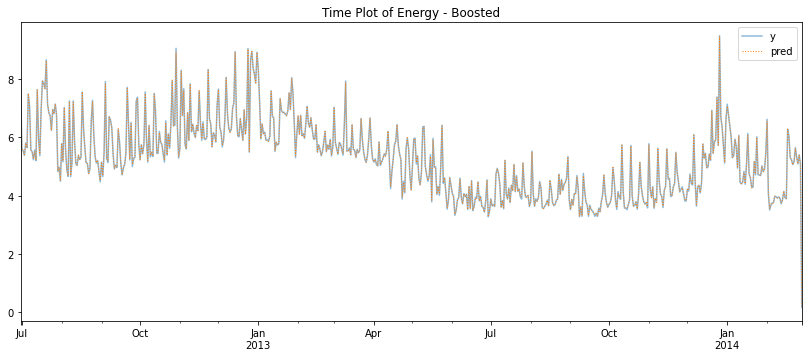

In [182]:
ax = y.plot(alpha=0.5, figsize=(14, 5.5))
#ax = y_pred["y_pred"].plot(ax=ax, linewidth=1, alpha=0.5)
ax = y_pred["y_pred_boosted"].plot(ax=ax, linewidth=1, alpha=1, linestyle=":", label="pred")
ax.set_title("Time Plot of Energy - Boosted")
plt.legend()
plt.show()

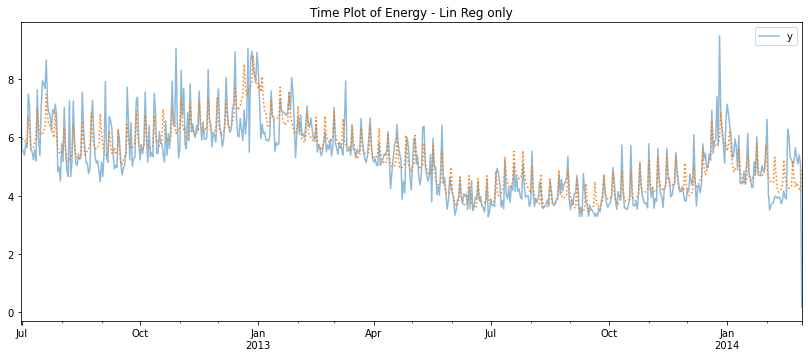

In [183]:
ax = y.plot(alpha=0.5, figsize=(14, 5.5))
ax = y_pred["y_pred"].plot(ax=ax, alpha=1, linestyle=":", label="pred")
#ax = y_pred["y_pred_boosted"].plot(ax=ax, linewidth=1, alpha=1)
ax.set_title("Time Plot of Energy - Lin Reg only")
plt.show()

In [ ]:
ax = y.plot(alpha=0.5, figsize=(14, 5.5))
#ax = y_pred["y_pred"].plot(ax=ax, linewidth=1, alpha=0.5)
ax = y_pred["y_pred_boosted"].plot(ax=ax, linewidth=1, alpha=1, linestyle=":", label="pred")
ax.set_title("Time Plot of Energy - Boosted")
plt.legend()
plt.show()

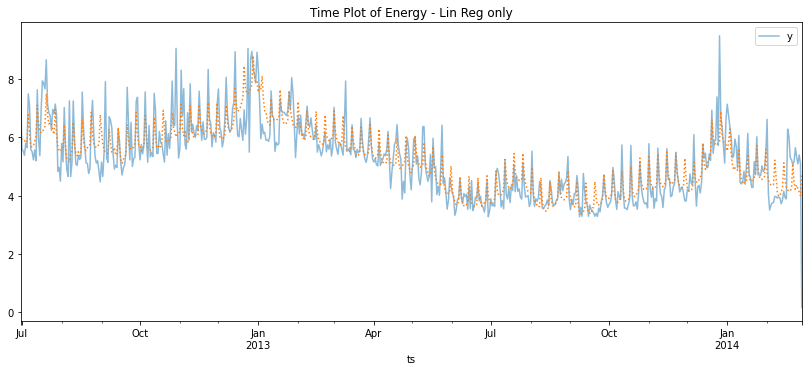

In [19]:
ax = y.plot(alpha=0.5, figsize=(14, 5.5))
ax = y_pred["y_pred"].plot(ax=ax, alpha=1, linestyle=":", label="pred")
#ax = y_pred["y_pred_boosted"].plot(ax=ax, linewidth=1, alpha=1)
ax.set_title("Time Plot of Energy - Lin Reg only")
plt.show()

## Quick attempt at future forecast
 - need to check this later, also boosted fit looks suspiciously overfit, check for leakage or overfitting

In [184]:
# Remove the last 30 days of data as we know this was a bit weird
X_1 = X_1[:-30]
X_2 = X_2[:-30]
y = y[:-30]

In [185]:
# Get train and validation data for the X1 and X2 models

X_1_train, X_1_valid, y_train, y_valid = train_test_split(
                                             X_1, y, 
                                             test_size=7,
                                             shuffle=False
                                            )

In [186]:
X_2_train, X_2_valid, y_train, y_valid = train_test_split(
                                             X_2, y, 
                                             test_size=7,
                                             shuffle=False
                                            )

In [187]:
# fit the two models on the training data
model.fit(X_1_train, X_2_train, y_train)

In [188]:
# run a self-predict on the train data and a future predict on the validation data

y_fit = model.predict(X_1_train, X_2_train)
y_fit = y_fit.clip(0.0)

In [189]:
y_pred = model.predict(X_1_valid, X_2_valid)
y_pred = y_pred.clip(0.0)

In [190]:
# Get errors
rmsle_train = mean_squared_log_error(y_train, y_fit.y_pred_boosted)**0.5
rmsle_test = mean_squared_log_error(y_valid, y_pred.y_pred_boosted)**0.5

print(f"Training RMSLE: {rmsle_train:.5f}")
print(f"Validation RMSLE: {rmsle_test:.5f}")

Training RMSLE: 0.00337
Validation RMSLE: 0.06632


In [26]:
# Get errors
rmsle_train = mean_squared_log_error(y_train, y_fit.y_pred_boosted)**0.5
rmsle_test = mean_squared_log_error(y_valid, y_pred.y_pred_boosted)**0.5

print(f"Training RMSLE: {rmsle_train:.5f}")
print(f"Validation RMSLE: {rmsle_test:.5f}")

Training RMSLE: 0.00509
Validation RMSLE: 0.05703


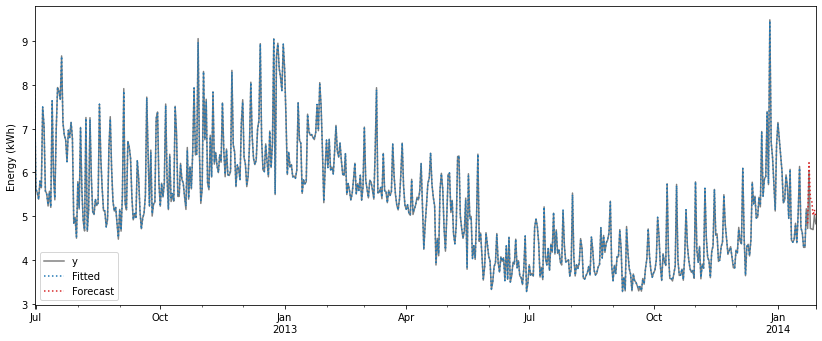

In [191]:
# plot the results

ax = y.plot(figsize=(14, 5.5), alpha=0.5, title="", ylabel="Energy (kWh)", color="k")
ax = y_fit.y_pred_boosted.plot(ax=ax, label="Fitted", color="C0", linestyle=":")
ax = y_pred.y_pred_boosted.plot(ax=ax, label="Forecast", color="C3", linestyle=":")
ax.legend()

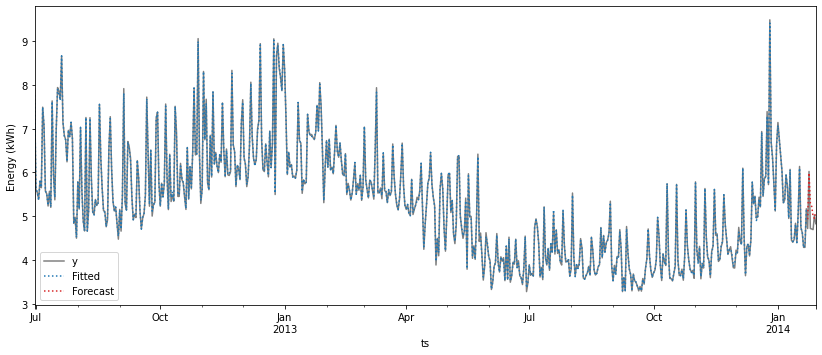

In [27]:
# plot the results

ax = y.plot(figsize=(14, 5.5), alpha=0.5, title="", ylabel="Energy (kWh)", color="k")
ax = y_fit.y_pred_boosted.plot(ax=ax, label="Fitted", color="C0", linestyle=":")
ax = y_pred.y_pred_boosted.plot(ax=ax, label="Forecast", color="C3", linestyle=":")
ax.legend()

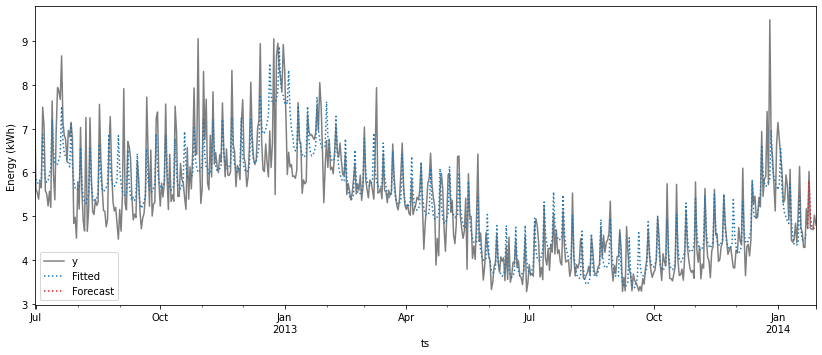

In [28]:
# plot the results without  boost

ax = y.plot(figsize=(14, 5.5), alpha=0.5, title="", ylabel="Energy (kWh)", color="k")
ax = y_fit.y_pred.plot(ax=ax, label="Fitted", color="C0", linestyle=":")
ax = y_pred.y_pred.plot(ax=ax, label="Forecast", color="C3", linestyle=":")
ax.legend()

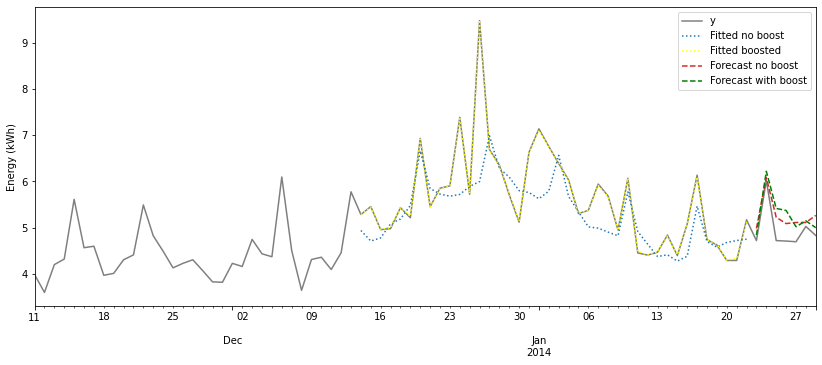

In [192]:
# zoom in

ax = y[-80:].plot(figsize=(14, 5.5), alpha=0.5, title="", ylabel="Energy (kWh)", color="black")
ax = y_fit.y_pred[-40:].plot(ax=ax, label="Fitted no boost", color="C0", linestyle=":")
ax = y_fit.y_pred_boosted[-40:].plot(ax=ax, label="Fitted boosted", color="yellow", linestyle=":")
ax = y_pred.y_pred.plot(ax=ax, label="Forecast no boost", color="C3", linestyle="--")
ax = y_pred.y_pred_boosted.plot(ax=ax, label="Forecast with boost", color="green", linestyle="--")
ax.legend()

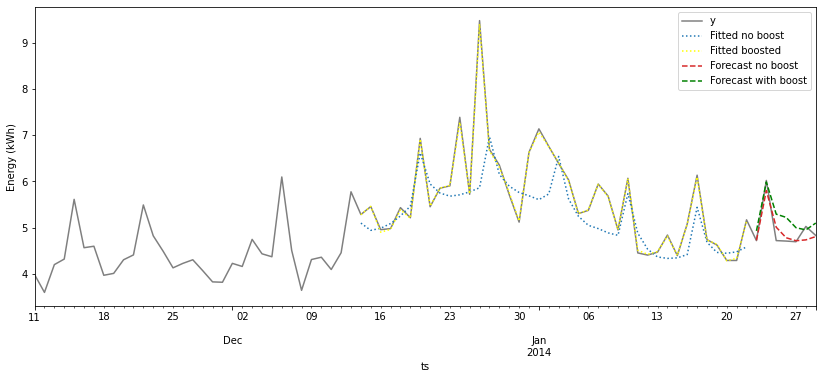

In [29]:
# zoom in

ax = y[-80:].plot(figsize=(14, 5.5), alpha=0.5, title="", ylabel="Energy (kWh)", color="black")
ax = y_fit.y_pred[-40:].plot(ax=ax, label="Fitted no boost", color="C0", linestyle=":")
ax = y_fit.y_pred_boosted[-40:].plot(ax=ax, label="Fitted boosted", color="yellow", linestyle=":")
ax = y_pred.y_pred.plot(ax=ax, label="Forecast no boost", color="C3", linestyle="--")
ax = y_pred.y_pred_boosted.plot(ax=ax, label="Forecast with boost", color="green", linestyle="--")
ax.legend()

In [193]:
rmsle_train_boost = mean_squared_log_error(y_train, y_fit.y_pred_boosted)**0.5
rmsle_test_boost = mean_squared_log_error(y_valid, y_pred.y_pred_boosted)**0.5

rmsle_train = mean_squared_log_error(y_train, y_fit.y_pred)**0.5
rmsle_test = mean_squared_log_error(y_valid, y_pred.y_pred)**0.5

print(f"Training boosted RMSLE: {rmsle_train_boost:.5f}")
print(f"Training not boosted RMSLE: {rmsle_train:.5f}")
print(f"Validation boosted RMSLE: {rmsle_test_boost:.5f}")
print(f"Validation not boosted RMSLE: {rmsle_test:.5f}")

Training boosted RMSLE: 0.00337
Training not boosted RMSLE: 0.08646
Validation boosted RMSLE: 0.06632
Validation not boosted RMSLE: 0.05828


In [30]:
rmsle_train_boost = mean_squared_log_error(y_train, y_fit.y_pred_boosted)**0.5
rmsle_test_boost = mean_squared_log_error(y_valid, y_pred.y_pred_boosted)**0.5

rmsle_train = mean_squared_log_error(y_train, y_fit.y_pred)**0.5
rmsle_test = mean_squared_log_error(y_valid, y_pred.y_pred)**0.5

print(f"Training boosted RMSLE: {rmsle_train_boost:.5f}")
print(f"Training not boosted RMSLE: {rmsle_train:.5f}")
print(f"Validation boosted RMSLE: {rmsle_test_boost:.5f}")
print(f"Validation not boosted RMSLE: {rmsle_test:.5f}")

Training boosted RMSLE: 0.00509
Training not boosted RMSLE: 0.08785
Validation boosted RMSLE: 0.05703
Validation not boosted RMSLE: 0.02950


## To do
 - add temp feature DONE
 - add holiday feature
 - add simple error metrics function for training and validation periods
 - add a sliding window approach for multiple validation period (or see if train-test split can be adapted)

In [38]:
weather = pd.read_csv("test_data/london_weather.csv", usecols=["tempmax", "tempmin", "temp",
                                                              "feelslike", "sunrise", "sunset",
                                                              "datetime"],
                     parse_dates=["datetime"], index_col=["datetime"])
weather.head()

,tempmax,tempmin,temp,feelslike,sunrise,sunset
datetime,,,,,,
2012-06-21,19.3,11.6,15.8,15.8,2012-06-21T04:43:14,2012-06-21T21:21:32
2012-06-22,18.3,11.5,14.9,14.9,2012-06-22T04:43:29,2012-06-22T21:21:40
2012-06-23,18.5,10.8,14.8,14.8,2012-06-23T04:43:47,2012-06-23T21:21:46
2012-06-24,20.6,11.6,15.7,15.7,2012-06-24T04:44:08,2012-06-24T21:21:49
2012-06-25,21.6,12.3,17.3,17.3,2012-06-25T04:44:32,2012-06-25T21:21:48


In [110]:
diff = pd.to_datetime(df_input["sunset"]) - pd.to_datetime(df_input["sunrise"])

In [111]:
diff/pd.to_timedelta(1, unit="h")

2012-06-21    16.638333
2012-06-22    16.636389
2012-06-23    16.633056
2012-06-24    16.628056
2012-06-25    16.621111
                ...    
2014-02-24    10.586111
2014-02-25    10.650833
2014-02-26    10.715556
2014-02-27    10.780556
2014-02-28    10.845833
Length: 618, dtype: float64

In [53]:
weather.shape

(618, 6)